<a href="https://colab.research.google.com/github/Ygrick/colab/blob/main/cats_vs_another.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Обучение

In [ ]:
# !pip install split-folders

In [ ]:
# import splitfolders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
from torch.utils.data import random_split, DataLoader
import numpy
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# splitfolders.ratio('/content/drive/MyDrive/PetImages/Images', output='/content/drive/MyDrive/PetImages/Output', ratio=(0.8, 0.2), move=False)

In [ ]:
# os.remove('/content/drive/MyDrive/PetImages/Output/train/Cat/666.jpg')

In [ ]:
data_dir = '/content/drive/MyDrive/PetImages/Output'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.6, p=0.2),
        transforms.Pad(padding=100), # попробовать
        transforms.RandomHorizontalFlip(p=0.2),
        # transforms.RandomRotation(degrees=(0, 180)),
        transforms.Resize([256,256]),
        # transforms.to_grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]
                                          ) for x in ['train', 'val']
                  }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=200,
                                             shuffle=True, num_workers=2) for x in ['train', 'val']} # batch_size = 128 - самый лучший

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(epoch)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/7
----------
train Loss: 0.1820 Acc: 0.9284
val Loss: 0.0932 Acc: 0.9720
0

Epoch 1/7
----------
train Loss: 0.0331 Acc: 0.9915
val Loss: 0.0643 Acc: 0.9794
1

Epoch 2/7
----------
train Loss: 0.0219 Acc: 0.9945
val Loss: 0.0556 Acc: 0.9809
2

Epoch 3/7
----------
train Loss: 0.0171 Acc: 0.9954
val Loss: 0.0466 Acc: 0.9851
3

Epoch 4/7
----------
train Loss: 0.0138 Acc: 0.9967
val Loss: 0.0487 Acc: 0.9827

Epoch 5/7
----------
train Loss: 0.0122 Acc: 0.9967
val Loss: 0.0505 Acc: 0.9830

Epoch 6/7
----------
train Loss: 0.0117 Acc: 0.9966
val Loss: 0.0471 Acc: 0.9851

Epoch 7/7
----------
train Loss: 0.0106 Acc: 0.9972
val Loss: 0.0435 Acc: 0.9863
7

Training complete in 34m 55s
Best val Acc: 0.986293


### СВОДКА

<function matplotlib.pyplot.show>

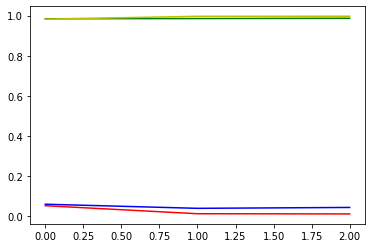

In [ ]:
plt.plot(val_loss, 'b')
plt.plot(train_loss, 'r')

plt.plot(val_acc, 'g')
plt.plot(train_acc, 'y')

plt.show

In [ ]:
model_ft.state_dict()

### СОХРАНЕНИЕ

In [ ]:
torch.save(model_ft, '/content/drive/MyDrive/igor_romaykin_cat_another.pt')
# model_ft = torch.load('/content/drive/MyDrive/igor_romaykin_cat_another.pt', map_location='cpu')

### Тест


In [ ]:
dir_group = '/content/drive/MyDrive/vk_api/pmmgo/'
images = []

test_data_transforms = (
        transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize([256,256]),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))


for file_name in os.listdir(dir_group):
  img = cv2.imread(os.path.join(dir_group, file_name))
  transform_image = test_data_transforms(img)
  images.append(transform_image)


In [ ]:
# model_ft.eval()
model_ft = model_ft.to('cpu')

In [ ]:
test_dataloaders = torch.utils.data.DataLoader(images)
predicts = []
for inputs in test_dataloaders:
  outputs = model_ft(inputs.to('cpu'))
  _, pred = torch.max(outputs, 1)
  predicts.append(pred)

In [ ]:
pred_list = list(map(lambda x: x.item(), predicts))
arr = numpy.array(pred_list)
len(arr)

233

In [ ]:
arr

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1])

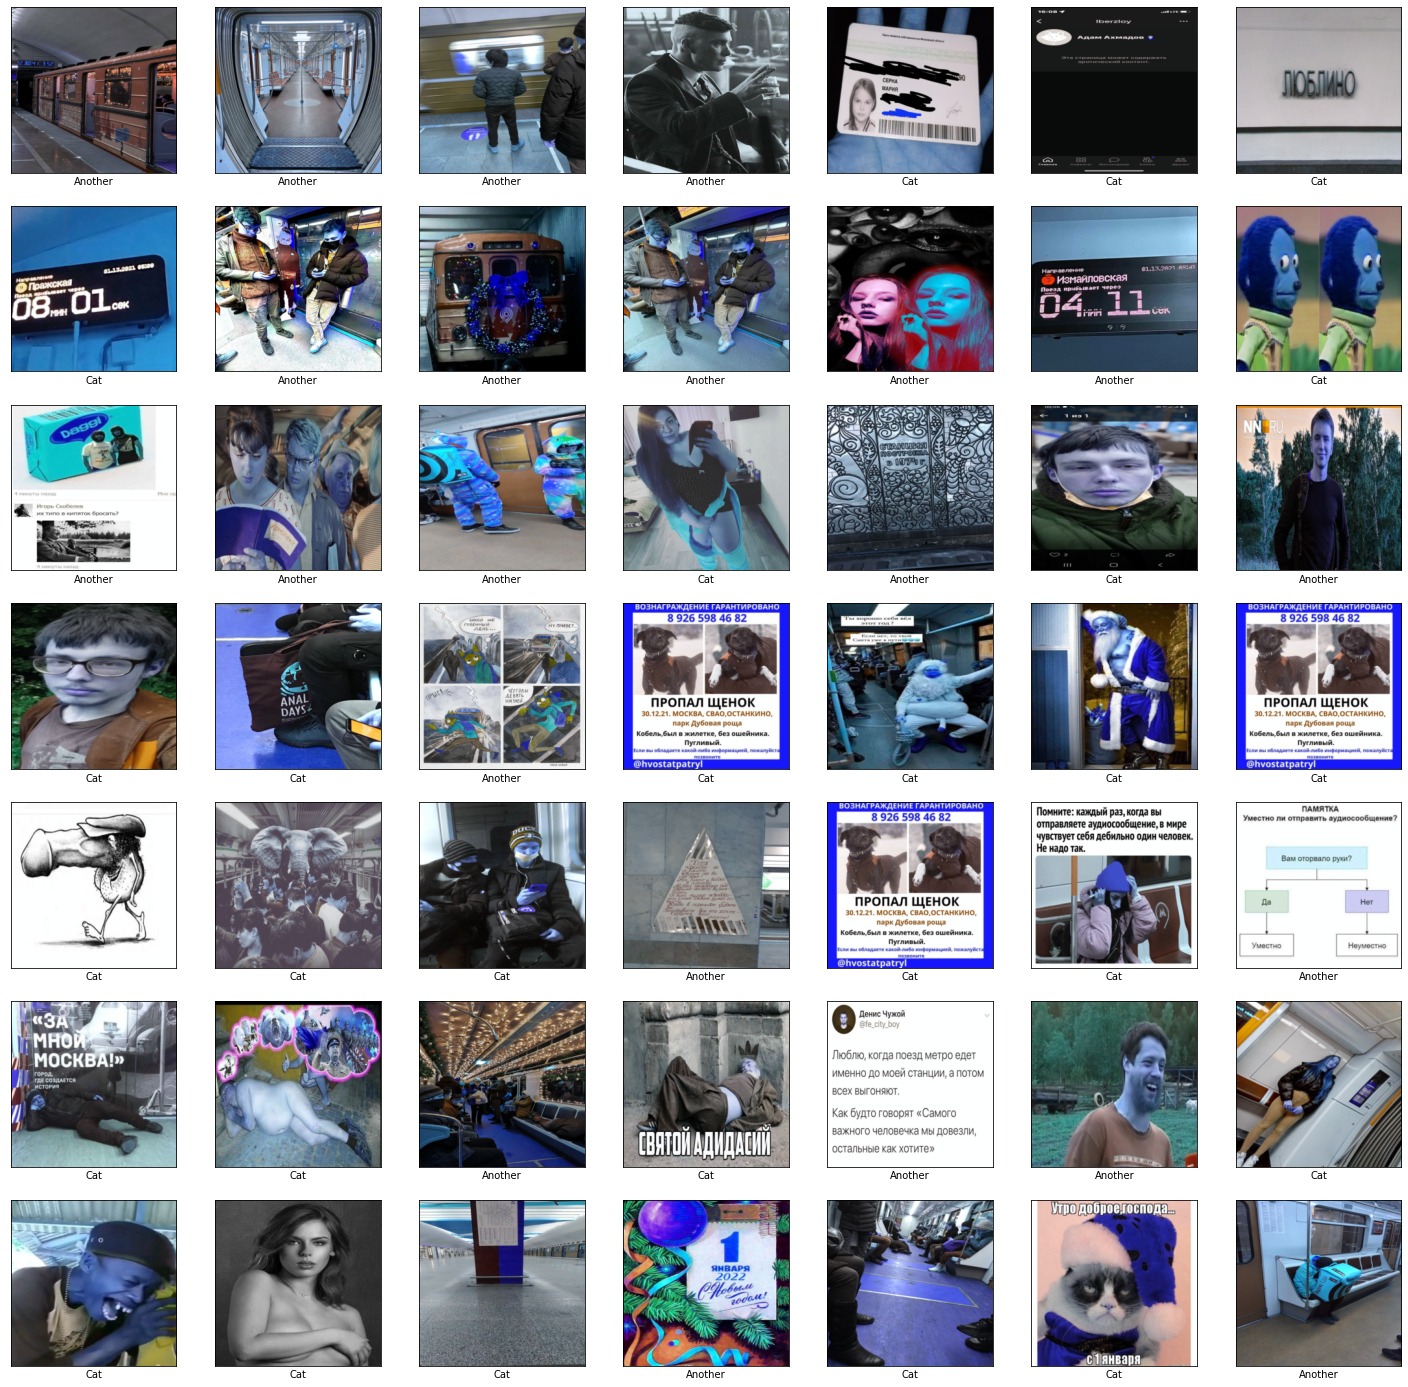

In [ ]:
plt.figure(figsize=(25, 25))
for i, inputs in enumerate(test_dataloaders):
  if i > 48:
    break
  # создание полотна
  plt.subplot(7, 7, i+1)
  plt.xticks([])
  plt.yticks([])

  # нормализация
  img = inputs[0].numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)

  # отображение
  plt.imshow(img)
  plt.xlabel(class_names[arr[i]], fontsize=10)